In [80]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN


In [81]:
import numpy as np
import pandas as pd
from os import listdir
from rdkit import Chem
from scipy.spatial.distance import cdist
from itertools import product
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

In [120]:
def GetAtomType(atom):
# This function takes an atom in a molecule and returns its type as defined for ECIF
    
    AtomType = [atom.GetSymbol(),
                str(atom.GetExplicitValence()),
                str(len([x.GetSymbol() for x in atom.GetNeighbors() if x.GetSymbol() != "H"])),
                str(len([x.GetSymbol() for x in atom.GetNeighbors() if x.GetSymbol() == "H"])),
                str(int(atom.GetIsAromatic())),
                str(int(atom.IsInRing())), 
               ]

    return("".join(AtomType))
def LoadSDFasDF(SDF):
# This function takes an SDF for a ligand as input and returns it as a pandas DataFrame with its atom types labeled according to ECIF
    
    m = Chem.MolFromMolFile(SDF, sanitize=False)
    m.UpdatePropertyCache(strict=False)
    
    ECIF_atoms = []

    for atom in m.GetAtoms():
        if atom.GetSymbol() != "H": # Include only non-hydrogen atoms
            entry = [int(atom.GetIdx())]
            entry.append(GetAtomType(atom))
            pos = m.GetConformer().GetAtomPosition(atom.GetIdx())
            entry.append(float("{0:.4f}".format(pos.x)))
            entry.append(float("{0:.4f}".format(pos.y)))
            entry.append(float("{0:.4f}".format(pos.z)))
            ECIF_atoms.append(entry)

    df = pd.DataFrame(ECIF_atoms)
    df.columns = ["ATOM_INDEX", "ATOM_TYPE","X","Y","Z"]
    return(df)


def LoadPDBasDF(PDB):
# This function takes a PDB for a protein as input and returns it as a pandas DataFrame with its atom types labeled according to ECIF

    ECIF_atoms = []
    
    f = open(PDB)
    for i in f:
        if i[:4] == "ATOM":
            # Include only non-hydrogen atoms
            if (len(i[12:16].replace(" ","")) < 4 and i[12:16].replace(" ","")[0] != "H") or (len(i[12:16].replace(" ","")) == 4 and i[12:16].replace(" ","")[1] != "H" and i[12:16].replace(" ","")[0] != "H"):
                ECIF_atoms.append([int(i[6:11]),
                         i[12:16]+"_"+i[17:20].replace(" ",""),
                         float(i[30:38]),
                         float(i[38:46]),
                         float(i[46:54])
                        ])
                
    f.close()
    
    df = pd.DataFrame(ECIF_atoms, columns=["ATOM_INDEX","ATOM_TYPE","X","Y","Z"])
    return(df)

def LoadPDBasDF_Solvent(PDB):
# This function takes a PDB for a protein as input and returns it as a pandas DataFrame with its atom types labeled according to ECIF

    ECIF_atoms = []
    
    f = open(PDB)
    for i in f:
        if i[:6] == "HETATM":
            # Include only non-hydrogen atoms
            ECIF_atoms.append([int(i[6:11]),
                         i[12:16]+"_"+i[17:20].replace(" ",""),
                         float(i[30:38]),
                         float(i[38:46]),
                         float(i[46:54])
                        ])
                
    f.close()
    
    df = pd.DataFrame(ECIF_atoms, columns=["ATOM_INDEX","ATOM_TYPE","X","Y","Z"])
    return(df)


# Atom Description 

### 1) Use ECIF descriptors for Ligand description: atom symbol, explicit valence, number of attached heavy atoms, number of attached hydrogens, aromaticity and ring membership
### 2) Use atom-aminoacid residues for protein description: Eg C-VAL
### 3) Use atom-molecule residues for solvent description


In [172]:
PDB_protein = './Solvent_SF/1snc_Protein.pdb'
SDF_ligand = './Solvent_SF/1snc_Ligand.sdf'
PDB_Solvent = './Solvent_SF/1snc_Solvent.pdb'

# Load both structures as pandas DataFrames
Target  = LoadPDBasDF(PDB_protein)
Solvent = LoadPDBasDF_Solvent(PDB_Solvent)
Ligand  = LoadSDFasDF(SDF_ligand)

#select protein/solvent atoms in a cubic box around the ligand, with a distance cutoff as 8Å
distance_cutoff=8
for i in ["X","Y","Z"]:
    Target = Target[Target[i] < float(Ligand[i].max())+distance_cutoff]
    Target = Target[Target[i] > float(Ligand[i].min())-distance_cutoff]
    Solvent = Solvent[Solvent[i] < float(Ligand[i].max())+distance_cutoff]
    Solvent = Solvent[Solvent[i] > float(Ligand[i].min())-distance_cutoff]

#Target
Solvent
#Ligand

,ATOM_INDEX,ATOM_TYPE,X,Y,Z
0,1,CA _CA,5.535,13.666,16.714
9,10,O _HOH,14.311,23.862,28.720
10,11,O _HOH,15.420,22.611,24.992
11,12,O _HOH,14.833,19.528,25.670
13,14,O _HOH,-1.368,22.768,23.699
14,15,O _HOH,0.662,22.946,25.526
15,16,O _HOH,1.996,21.038,27.749
16,17,O _HOH,3.675,28.292,24.669
19,20,O _HOH,2.776,21.427,33.536
22,23,O _HOH,10.383,11.522,14.354


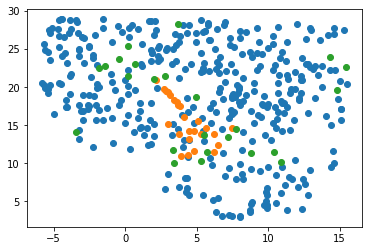

In [118]:
#Plot a 2D dot plot to get overview of the selected atom source and number.
pyplot.scatter(Target["X"], Target["Y"])
pyplot.scatter(Ligand["X"], Ligand["Y"])
pyplot.scatter(Solvent["X"], Solvent["Y"])
pyplot.show()



## Get Ligand-protein, Ligand-solvent, protein-solvent atom type.


In [125]:
#Ligand-protein pairs

def Get_PL_Pairs(Target, Ligand, distance_cutoff=6.0):
# This function returns the protein-ligand atom-type pairs for a given distance cutoff    
    # Get all possible pairs
    Pairs = list(product(Target["ATOM_TYPE"], Ligand["ATOM_TYPE"]))
    Pairs = [x[0]+"-"+x[1] for x in Pairs]
    Pairs = pd.DataFrame(Pairs, columns=["ATOM_PAIR"])
    Distances = cdist(Target[["X","Y","Z"]], Ligand[["X","Y","Z"]], metric="euclidean")
    Distances = Distances.reshape(Distances.shape[0]*Distances.shape[1],1)
    Distances = pd.DataFrame(Distances, columns=["DISTANCE"])

    Pairs = pd.concat([Pairs,Distances], axis=1)
    Pairs = Pairs[Pairs["DISTANCE"] <= distance_cutoff].reset_index(drop=True)
    # Pairs from ELEMENTS could be easily obtained froms pairs from ECIF
    #Pairs["ELEMENTS_PAIR"] = [x.split("-")[0].split(";")[0]+"-"+x.split("-")[1].split(";")[0] for x in Pairs["ECIF_PAIR"]]
    return Pairs

In [201]:
df_LT = Get_PL_Pairs(Ligand, Target, distance_cutoff=5.0)
df_LS = Get_PL_Pairs(Ligand,Solvent, distance_cutoff=5.0)
df_ST = Get_PL_Pairs(Solvent,Target, distance_cutoff=5.0)


In [202]:
len(df_LS),len(df_ST)

(52, 360)

In [206]:
'''df_LS["Connect"]=0
df_ST["Connect"]=0

for i in range(len(df_LS)):
    for j in range(len(df_ST)):
        if df_LS["ATOM_INDEX"].iloc[i].split("-")[1] == df_ST["ATOM_INDEX"].iloc[j].split("-")[0]:
            df_LS["Connect"] = 1
            df_ST["Connect"] = 1
df_LS[df_LS["Connect"]==1]
df_ST[df_ST["Connect"]==1]            
'''
            
Solv_node = {} 
for i in Solvent["ATOM_TYPE"]:
    Solv_node[i] = [] 
for i in range(len(df_LS)):
    LS = df_LS.iloc[i]
    key = LS["ATOM_PAIR"].split("-")[1]
    content = ["L_"+LS["ATOM_PAIR"].split("-")[0],LS["DISTANCE"]]
    Solv_node[key].append(content)
for i in range(len(df_ST)):
    ST = df_ST.iloc[i]
    key = ST["ATOM_PAIR"].split("-")[0]
    content = ["T_"+ST["ATOM_PAIR"].split("-")[1],ST["DISTANCE"]]
    Solv_node[key].append(content)

Solv_node
    

{'CA  _CA': [['L_P54000', 3.9301044515381527],
  ['L_O11000', 2.73809094078338],
  ['L_O11000', 4.1755472695204885],
  ['L_O21000', 4.642587855926908],
  ['T_ OD1_ASP', 4.721940808608255],
  ['T_ CB _ASP', 4.637722393589335],
  ['T_ CG _ASP', 3.2440924771035737],
  ['T_ OD1_ASP', 2.3854999476000818],
  ['T_ OD2_ASP', 3.4246034806967054],
  ['T_ NE _ARG', 4.59407553268337],
  ['T_ CZ _ARG', 4.385643054330801],
  ['T_ NH2_ARG', 3.770596371928451],
  ['T_ CA _ASP', 4.371256684295719],
  ['T_ C  _ASP', 4.456481347430952],
  ['T_ CB _ASP', 4.594089898989788],
  ['T_ CG _ASP', 3.509033627653061],
  ['T_ OD1_ASP', 2.314343319388893],
  ['T_ OD2_ASP', 4.16107510146116],
  ['T_ N  _THR', 3.763282609637494],
  ['T_ CA _THR', 4.441531942922396],
  ['T_ C  _THR', 3.85811871253335],
  ['T_ O  _THR', 2.6726232431826213],
  ['T_ OG1_THR', 4.1154469988082685],
  ['T_ N  _PRO', 4.9571928548322575],
  ['T_ C  _PRO', 4.944954600398268],
  ['T_ N  _GLU', 4.946037302730338],
  ['T_ OE1_GLU', 4.695138869085

In [139]:
"P54000- O _HOH".split("-")[1]

['P54000', ' O _HOH']

In [140]:
"CA _CA- CG _ASP".split("-")[0]

'CA _CA'

In [131]:
df_LS["ATOM_PAIR"].split("-")[1] == df_ST["ATOM_PAIR"].split("-")[0]

,ATOM_PAIR,DISTANCE
0,P54000- O _HOH,5.650221
1,P54000-CA _CA,3.930104
2,P54000- O _HOH,3.410219
3,P54000- O _HOH,3.709777
4,P54000- O _HOH,5.755166
...,...,...
83,C11000- O _HOH,5.796321
84,C11000- O _HOH,3.504238
85,C32001- O _HOH,5.640091
86,C32001- O _HOH,5.296483


In [132]:
df_ST

,ATOM_PAIR,DISTANCE
0,CA _CA- CG _ASP,5.644936
1,CA _CA- OD1_ASP,4.721941
2,CA _CA- OD2_ASP,5.812558
3,CA _CA- N _ASP,5.681207
4,CA _CA- CA _ASP,5.693942
...,...,...
615,O _HOH- CE _LYS,2.979445
616,O _HOH- NZ _LYS,3.195454
617,O _HOH- CE1_TYR,5.784072
618,O _HOH- CZ _TYR,5.304688


In [2]:
# initialize the data set we'll work with
training_data, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=4
)
#3Dprotein orthogonal data as input




array([[ 1.22515974, -0.95173116],
       [ 1.01630365, -1.72517506],
       [ 0.33534004, -1.7248955 ],
       ...,
       [ 1.54270795, -0.05566478],
       [ 0.81664566, -1.2509187 ],
       [ 1.13782254, -1.26151957]])

In [15]:
# define the model
dbscan_model = DBSCAN(eps=0.25, min_samples=9)

# train the model
dbscan_model.fit(training_data)

# assign each data point to a cluster
dbscan_result = dbscan_model.fit_predict(training_data)

# get all of the unique clusters
dbscan_clusters = unique(dbscan_result)


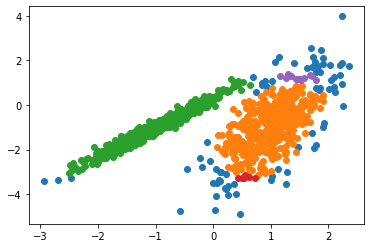

In [18]:
# plot the DBSCAN clusters
for dbscan_cluster in dbscan_clusters:
    # get data points that fall in this cluster
    index = where(dbscan_result == dbscan_cluster)
    # make the plot
    pyplot.scatter(training_data[index, 0], training_data[index, 1])

# show the DBSCAN plot
pyplot.show()

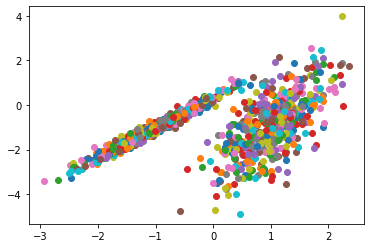

In [9]:
'''for index in range(1000): 
    pyplot.scatter(training_data[index, 0], training_data[index, 1])
pyplot.show()'''

In [23]:
'''def GetPLPairs(PDB_protein, SDF_ligand, distance_cutoff=6.0):
# This function returns the protein-ligand atom-type pairs for a given distance cutoff
    
    # Load both structures as pandas DataFrames
    Target = LoadPDBasDF(PDB_protein)
    Ligand = LoadSDFasDF(SDF_ligand)
    
    # Take all atoms from the target within a cubic box around the ligand considering the "distance_cutoff criterion"
    for i in ["X","Y","Z"]:
        Target = Target[Target[i] < float(Ligand[i].max())+distance_cutoff]
        Target = Target[Target[i] > float(Ligand[i].min())-distance_cutoff]
    
    # Get all possible pairs
    Pairs = list(product(Target["ECIF_ATOM_TYPE"], Ligand["ECIF_ATOM_TYPE"]))
    Pairs = [x[0]+"-"+x[1] for x in Pairs]
    Pairs = pd.DataFrame(Pairs, columns=["ECIF_PAIR"])
    Distances = cdist(Target[["X","Y","Z"]], Ligand[["X","Y","Z"]], metric="euclidean")
    Distances = Distances.reshape(Distances.shape[0]*Distances.shape[1],1)
    Distances = pd.DataFrame(Distances, columns=["DISTANCE"])

    Pairs = pd.concat([Pairs,Distances], axis=1)
    Pairs = Pairs[Pairs["DISTANCE"] <= distance_cutoff].reset_index(drop=True)
    # Pairs from ELEMENTS could be easily obtained froms pairs from ECIF
    Pairs["ELEMENTS_PAIR"] = [x.split("-")[0].split(";")[0]+"-"+x.split("-")[1].split(";")[0] for x in Pairs["ECIF_PAIR"]]
    return Pairs'''